In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.strtree import STRtree
from shapely.ops import unary_union
from datetime import timedelta
import pandas as pd
import numpy as np

In [2]:
# raw TWIG (treatment) data
data = gpd.read_file('/oak/stanford/groups/konings/ashdef/TWIG/treatment_index.gdb')

/home/users/ashdef/.local/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(


# Checking for overlapping treatment activities, filtering out overlaps, & figuring out the time gap between overlapping activities

In [3]:
# filtering twig data to only include treatments in the western us
western_states = ['CA', 'OR', 'WA', 'ID', 'MT', 'WY', 'UT', 'AZ', 'CO', 'NM']

wus_trmts = data[data['state'].isin(western_states)]
wus_trmts.shape
wus_trmts.columns

Index(['unique_id', 'name', 'state', 'acres', 'treatment_date', 'date_source',
       'identifier_database', 'date_current', 'actual_completion_date',
       'activity_code', 'activity', 'method', 'equipment', 'category', 'type',
       'twig_category', 'agency', 'fund_source', 'fund_code', 'total_cost',
       'cost_per_uom', 'uom', 'error', 'shape_Length', 'shape_Area',
       'geometry'],
      dtype='object')

https://deepwiki.com/shapely/shapely/8.1-strtree-implementation

In [4]:
# spatial indices for treatment polygons - used help from chatGPT for this cell and next
geoms = list(wus_trmts.geometry)
tree = STRtree(geoms)

In [5]:
non_overlapping = [] # list of indices for polygons that aren't overlapping another

time_diffs = []  # store time differences in days between overlapping treatments
overlapping = [] # list of indices for polygons that are overlapping another


#loop over treatment polygons
for i, geom in enumerate(geoms):
    # which polygons maybe intersect?
    possible_matches_idx = tree.query(geom) # this returns indices, not geometries

    # check each possible match
    overlaps = False
    for j in possible_matches_idx:
        if i == j: # skip if the current polygon is being looked at
            continue  

        # if polygons do intersect, check how far apart the treatment dates are
        if geom.intersects(geoms[j]):
            overlaps = True
            
            date_i = wus_trmts['treatment_date'].iloc[i]
            date_j = wus_trmts['treatment_date'].iloc[j]

            # calculate  time difference
            delta = abs((date_i - date_j).days)
            time_diffs.append(delta)
            overlapping.append((i, j)) 
            
            break  

    if not overlaps:
        non_overlapping.append(i)

# filter out the original geodataframe to only include unique treatment areas
wus_trmts_unique = wus_trmts.iloc[non_overlapping]


#wus_trmts_unique.to_file("wus_trmts_unique.shp")

In [15]:
time_diffs = pd.read_csv("time_diffs.txt", header=None)[0].tolist()
np.mean(time_diffs)

2946.1301928674998

In [70]:
time_diffs = np.array(time_diffs)

In [73]:
time_diffs_1day = time_diffs[time_diffs == 1]
print(len(time_diffs_1day))
print("% overlapping treatments 1 day apart = ", len(time_diffs_1day)/len(time_diffs)*100)

4169
% overlapping treatments 1 day apart =  0.420074503019317


In [74]:
time_diffs_3day = time_diffs[time_diffs <4]
print(len(time_diffs_3day))
print("% overlapping treatments 3 days apart or less ", len(time_diffs_3day)/len(time_diffs)*100)

178024
% overlapping treatments 3 days apart or less  17.93795714212302


In [60]:
time_diffs_1yr = time_diffs_years[time_diffs_years<1]
len(time_diffs_1yr)

306652

% overlapping treatments < 1 yr apart =  30.898701487138304


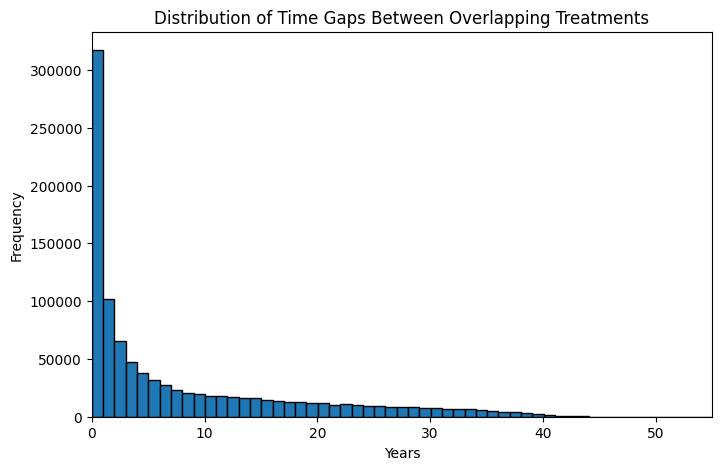

In [61]:
plt.figure(figsize=(8,5))

time_diffs_years = np.array(time_diffs) / 365

# one bar per year
plt.hist(time_diffs_years, bins=int(time_diffs_years.max()), edgecolor='black')
plt.xlim(0, 55)
plt.xlabel("Years")
plt.ylabel("Frequency")
plt.title("Distribution of Time Gaps Between Overlapping Treatments")
print("% overlapping treatments < 1 yr apart = ", len(time_diffs_1yr)/len(time_diffs_years)*100)

In [62]:
time_diffs_1month = time_diffs_years[time_diffs_years<1/12]
len(time_diffs_1month)
print("% overlapping treatments < 1 month apart = ", len(time_diffs_1month)/len(time_diffs_years)*100)


196169

In [64]:
time_diffs_1week = time_diffs_years[time_diffs_years<1/52]
print(len(time_diffs_1week))
print("% overlapping treatments < 1 week apart = ", len(time_diffs_1week)/len(time_diffs_years)*100)

181109
% overlapping treatments < 1 week apart =  18.24880622867006


In [8]:
wus_trmts_unique = gpd.read_file("/home/users/ashdef/TWIG_SFE/TWIG_no_overlap/wus_trmts_unique.shp")
wus_trmts_unique

,unique_id,name,state,acres,treatment_,date_sourc,identifier,date_curre,actual_com,activity_c,...,agency,fund_sourc,fund_code,total_cost,cost_per_u,uom,error,shape_Leng,shape_Area,geometry
0,AC30515201035510355,TSMRS LEGACY STAND,MT,25.387,2002-08-01,date_completed,FACTS Common Attributes,2022-09-08,2002-08-01,1117,...,USFS,Other,NFND,0.000,0.0,ACRES,None,3045.317914,2.086794e+05,"POLYGON Z ((-11790486.34 5691665.934 -100000, ..."
1,AC37088401036110361,TSMRS LEGACY STAND,ID,27.989,1990-09-01,date_completed,FACTS Common Attributes,2022-09-08,1990-09-01,1113,...,USFS,Hazardous Fuels Reduction,WFHF,0.000,0.0,ACRES,None,2228.254965,2.376036e+05,"POLYGON Z ((-12849958.371 5835671.608 -100000,..."
2,AC79680901035910359,TSMRS LEGACY STAND,ID,22.093,2005-04-04,act_created_date,FACTS Common Attributes,2022-09-08,NaT,4521,...,USFS,Other,NFVW,0.000,0.0,ACRES,None,1989.757513,1.972523e+05,"POLYGON Z ((-12938471.414 6057021.115 -100000,..."
3,AC13334901027710277,TSMRS LEGACY STAND,ID,38.625,1985-10-01,date_completed,FACTS Common Attributes,2022-09-08,1985-10-01,1130,...,USFS,Other,NFVW,3283.125,85.0,ACRES,None,3220.730703,3.222062e+05,"POLYGON Z ((-12901453.758 5758169.855 -100000,..."
4,AC101483401035910359,PACKER CRK,ID,32.604,2005-04-06,act_created_date,FACTS Common Attributes,2025-02-18,NaT,4521,...,USFS,Other,NFVW,0.000,0.0,ACRES,None,2597.335119,3.031142e+05,"POLYGON Z ((-13021978.102 6230886.77 -100000, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27124,7122137010602,SERAL RUSHING FR F7,CA,12.908,2024-09-23,date_planned,FACTS Hazardous Fuels,2025-02-14,NaT,1160,...,USFS,BIL,HX08,NaN,NaN,ACRES,None,1827.315424,8.451129e+04,"POLYGON Z ((-13374868.486 4595103.961 -100000,..."
27125,6956726010602,CHILCOOT FIRE,ID,347.988,2023-11-30,date_completed,FACTS Hazardous Fuels,2025-02-14,2023-11-30,1117,...,USFS,Other,WFSE,86997.000,250.0,ACRES,None,19688.753869,2.792218e+06,MULTIPOLYGON Z (((-12843501.957 5582861.543 -1...
27126,AC1770461010602,TOBOGGAN RIDGE FUELS 06,ID,470.795,2008-07-01,date_completed,FACTS Hazardous Fuels,2025-02-14,2008-07-01,6101,...,USFS,Hazardous Fuels Reduction,WFHF,14123.850,30.0,ACRES,None,11521.115477,4.041538e+06,"POLYGON Z ((-12806943.552 5883334.734 -100000,..."
27127,AC1976893010602,None,WY,3.182,2010-10-20,date_completed,FACTS Hazardous Fuels,2025-02-14,2010-10-20,4521,...,USFS,Other,NFVW,451.844,142.0,ACRES,None,614.972227,2.262978e+04,"POLYGON Z ((-11829665.679 5012370.196 -100000,..."


In [10]:
wus_trmts_unique.columns

Index(['unique_id', 'name', 'state', 'acres', 'treatment_', 'date_sourc',
       'identifier', 'date_curre', 'actual_com', 'activity_c', 'activity',
       'method', 'equipment', 'category', 'type', 'twig_categ', 'agency',
       'fund_sourc', 'fund_code', 'total_cost', 'cost_per_u', 'uom', 'error',
       'shape_Leng', 'shape_Area', 'geometry'],
      dtype='object')

<Figure size 1200x800 with 0 Axes>

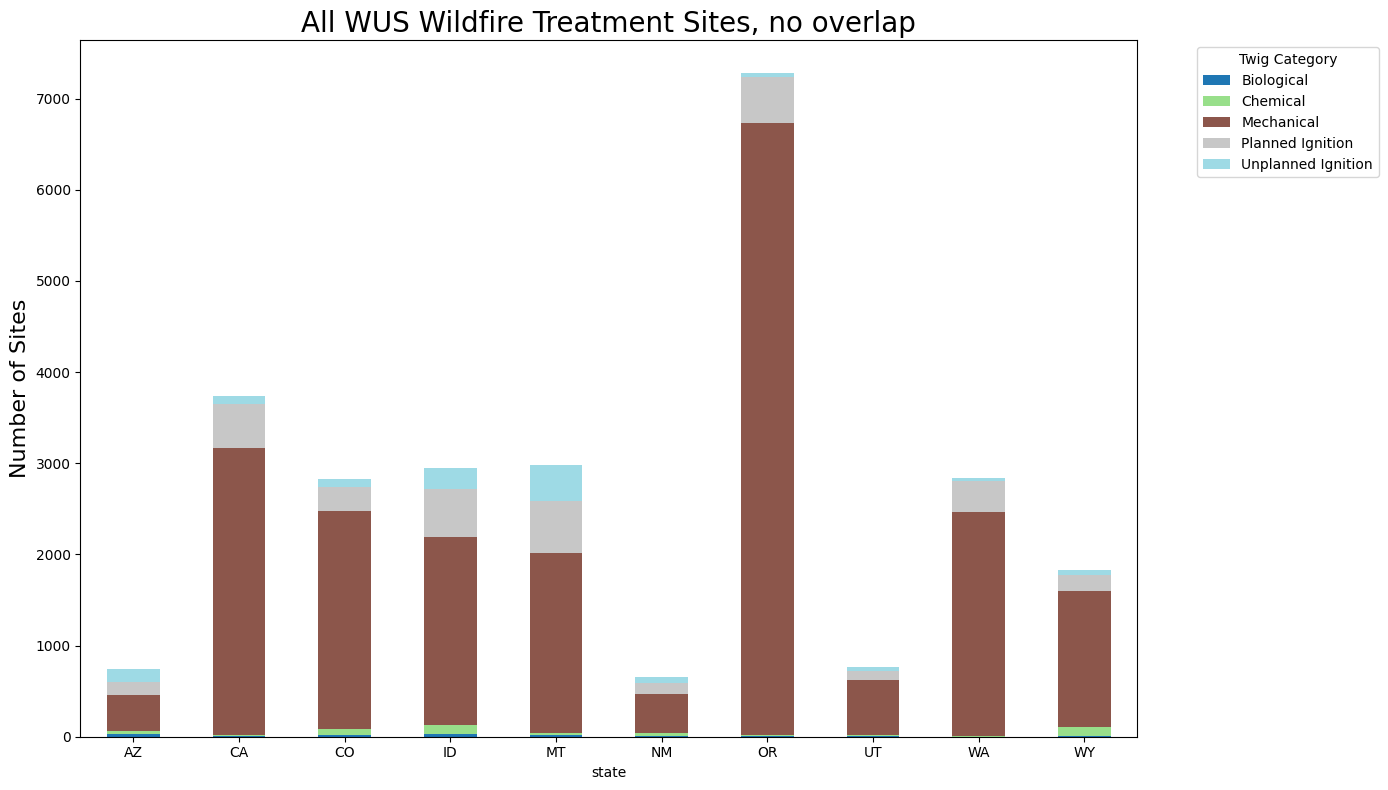

In [13]:
grouped = wus_trmts_unique.groupby(['state', 'twig_categ']).size().reset_index(name='count')

pivot_df = grouped.pivot(index='state', columns='twig_categ', values='count').fillna(0)

plt.figure(figsize=(12, 8))
pivot_df.plot(kind='bar', stacked=True, colormap='tab20', figsize=(14, 8))
plt.xticks(rotation = 0)
plt.ylabel('Number of Sites', fontsize = 16)
plt.title('All WUS Wildfire Treatment Sites, no overlap', fontsize = 20)
plt.legend(title='Twig Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()



## Refining above filtering to only eliminate overlapping treatment activities > 3 days apart, based on time gap analysis

In [4]:
western_states = ['CA', 'OR', 'WA', 'ID', 'MT', 'WY', 'UT', 'AZ', 'CO', 'NM']

wus_trmts = data[data['state'].isin(western_states)]
wus_trmts.shape
wus_trmts.columns

Index(['unique_id', 'name', 'state', 'acres', 'treatment_date', 'date_source',
       'identifier_database', 'date_current', 'actual_completion_date',
       'activity_code', 'activity', 'method', 'equipment', 'category', 'type',
       'twig_category', 'agency', 'fund_source', 'fund_code', 'total_cost',
       'cost_per_uom', 'uom', 'error', 'shape_Length', 'shape_Area',
       'geometry'],
      dtype='object')

In [6]:
# spatial indices for treatment polygons
geoms = list(wus_trmts.geometry)
tree = STRtree(geoms)

In [7]:
non_overlapping = [] # list of indices for polygons that aren't overlapping another

overlapping = [] # list of indices for polygons that are overlapping another


#loop over polygons
for i, geom in enumerate(geoms):
    # which polygons maybe intersect?
    possible_matches_idx = tree.query(geom) # this returns indices, not geometries

    # check each possible match
    overlaps = False
    for j in possible_matches_idx:
        if i == j: # skip if the current polygon is being looked at
            continue  

        # if polygons do intersect, check how far apart the treatment dates are
        if geom.intersects(geoms[j]):
            
            date_i = wus_trmts['treatment_date'].iloc[i]
            date_j = wus_trmts['treatment_date'].iloc[j]

            # calculate  time difference
            delta = abs((date_i - date_j).days)

            if delta > 3: # if the treatment completion dates are more than 3 days apart, consider it overlapping. Do not include either of these sites in treatment data
                overlaps = True
                overlapping.append((i, j))                 
                
            break  

    if not overlaps:
        non_overlapping.append(i) # this will now include intersecting treatments that occurred within 3 days

# filter out the original geodataframe to only include unique treatment areas
wus_trmts_unique_3day = wus_trmts.iloc[non_overlapping]


wus_trmts_unique_3day.to_file("wus_trmts_unique_3day.shp")

/tmp/ipykernel_451/882307300.py:39: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  wus_trmts_unique_3day.to_file("wus_trmts_unique_3day.shp")
/home/users/ashdef/.local/lib/python3.9/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'treatment_date' to 'treatment_'
  ogr_write(
/home/users/ashdef/.local/lib/python3.9/site-packages/pyogrio/raw.py:723: RuntimeWarning: Field treatment_ create as date field, though DateTime requested.
  ogr_write(
/home/users/ashdef/.local/lib/python3.9/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'date_source' to 'date_sourc'
  ogr_write(
/home/users/ashdef/.local/lib/python3.9/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'identifier_database' to 'identifier'
  ogr_write(
/home/users/ashdef/.local/lib/python3.9/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'd

In [8]:
wus_trmts_unique_3day

,unique_id,name,state,acres,treatment_date,date_source,identifier_database,date_current,actual_completion_date,activity_code,...,agency,fund_source,fund_code,total_cost,cost_per_uom,uom,error,shape_Length,shape_Area,geometry
8,AC31101801036410364,TSMRS LEGACY STAND,MT,9.786,2002-09-01 00:00:00+00:00,date_completed,FACTS Common Attributes,2022-09-08 17:19:43+00:00,2002-09-01 00:00:00+00:00,4494,...,USFS,Other,CONT,0.00000,0.00,ACRES,None,1176.399159,79493.391709,MULTIPOLYGON Z (((-12393113.55 5637851.893 -10...
10,AC31101701036410364,TSMRS LEGACY STAND,MT,9.786,2002-09-01 00:00:00+00:00,date_completed,FACTS Common Attributes,2022-09-08 17:18:15+00:00,2002-09-01 00:00:00+00:00,4452,...,USFS,Other,NFND,0.00000,0.00,ACRES,None,1176.399159,79493.391709,MULTIPOLYGON Z (((-12393113.55 5637851.893 -10...
20,AC31928101027710277,TSMRS LEGACY STAND,ID,47.685,1990-08-01 00:00:00+00:00,date_completed,FACTS Common Attributes,2022-09-08 17:17:06+00:00,1990-08-01 00:00:00+00:00,4494,...,USFS,Other,PPPP,0.00000,0.00,ACRES,None,3352.241661,396929.361889,MULTIPOLYGON Z (((-12866398.782 5748465.897 -1...
21,AC11802401025910259,TSMRS LEGACY STAND,MT,14.033,2003-09-01 00:00:00+00:00,date_completed,FACTS Common Attributes,2022-09-08 17:21:37+00:00,2003-09-01 00:00:00+00:00,1117,...,USFS,Other,NFND,0.00000,0.00,ACRES,None,1653.301125,127844.535094,MULTIPOLYGON Z (((-12675384.798 6144308.149 -1...
26,AC99974101035910359,S FORK GOLD UNIT 13,ID,7.699,1993-07-01 00:00:00+00:00,date_completed,FACTS Common Attributes,2022-09-08 17:15:00+00:00,1993-07-01 00:00:00+00:00,1153,...,USFS,Other,BDBD,1986.34200,258.00,ACRES,None,1145.775633,71747.884899,MULTIPOLYGON Z (((-13024178.121 6241008.785 -1...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374254,6991388010602,WEST CRYSTAL IRSC,CO,26.152,2024-09-01 00:00:00+00:00,date_planned,FACTS Hazardous Fuels,2025-02-14 04:04:05+00:00,NaT,1160,...,USFS,Other,IRHF,30551.55096,1168.23,ACRES,None,2175.727791,185344.429244,MULTIPOLYGON Z (((-11765006.401 4995371.487 -1...
1374255,6991389010602,WEST CRYSTAL IRSC,CO,26.152,2024-09-01 00:00:00+00:00,date_planned,FACTS Hazardous Fuels,2025-02-14 04:04:05+00:00,NaT,1120,...,USFS,Other,IRHF,83686.40000,3200.00,ACRES,None,2175.727791,185344.429244,MULTIPOLYGON Z (((-11765006.401 4995371.487 -1...
1374271,AC1964770010602,7MILE FRLTSC-TU:07,CO,4.741,2011-08-15 00:00:00+00:00,date_completed,FACTS Hazardous Fuels,2025-02-14 04:04:06+00:00,2011-08-15 00:00:00+00:00,4121,...,USFS,Hazardous Fuels Reduction,WFHF,4019.79908,847.88,ACRES,None,944.777253,33465.909818,MULTIPOLYGON Z (((-11758470.529 4975299.671 -1...
1374272,AC1964771010602,7MILE FRLTSC-TU:07,CO,4.741,2011-08-15 00:00:00+00:00,date_completed,FACTS Hazardous Fuels,2025-02-14 04:04:06+00:00,2011-08-15 00:00:00+00:00,1120,...,USFS,Hazardous Fuels Reduction,WFHF,4019.79908,847.88,ACRES,None,944.777253,33465.909818,MULTIPOLYGON Z (((-11758470.529 4975299.671 -1...


## Merging overlapping treatment activities that occured within three days of each other

In [ ]:
# this only includes sites for western US states
# All treatment activities occur over a unique area, or overlap with another that occurred less than three days before/after
twig_data = gpd.read_file('/oak/stanford/groups/konings/ashdef/TWIG/TWIG_3day_no_overlap/wus_trmts_unique_3day.shp')
twig_data

In [ ]:
twig_data.shape

In [1]:
# identify overlapping groups
sindex = twig_data.sindex # creating spatial index

# this list will hold sets of indices belonging to the same overlapping group
groups = []
visited = set()

for i, geom in enumerate(twig_data.geometry): # loop over twig polygons
    if i in visited: # geometry is already in a group 
        continue

    # find all geometries that intersect this one
    possible_matches_idx = list(sindex.intersection(geom.bounds))
    matches = twig_data.iloc[possible_matches_idx]
    overlaps = matches[matches.intersects(geom)]

    # initialize the current group
    group = set(overlaps.index)

    # expand the group by checking intersections recursively - used chatGPT for help with this
    changed = True
    while changed:
        changed = False
        new_group = set(group)
        for j in list(group):
            possible = list(sindex.intersection(twig_data.geometry.iloc[j].bounds))
            new_overlaps = twig_data.iloc[possible]
            intersecting = new_overlaps[new_overlaps.intersects(twig_data.geometry.iloc[j])]
            new_group |= set(intersecting.index)
        if new_group != group:
            group = new_group
            changed = True

    groups.append(group)
    visited |= group

# merge
merged_rows = []
for group in groups:
    subset = twig_data.loc[list(group)]

    merged_geom = unary_union(subset.geometry)
    latest_date = subset['treatment_'].max()
    merged_twigs = ", ".join(sorted(set(subset['twig_categ'].fillna("Unknown"))))
    
    # aggregate attributes
    merged_rows.append({
        "geometry": merged_geom,
        "treatment_": latest_date,
        "twig_categ": merged_twigs
    })

# create merged GeoDataFrame
merged_gdf = gpd.GeoDataFrame(merged_rows, crs=twig_data.crs)
merged_gdf.to_file("/oak/stanford/groups/konings/ashdef/TWIG/TWIG_3day_no_overlap/wus_trmts_merged_3day.shp")


NameError: name 'twig_data' is not defined

In [9]:
twig_data = gpd.read_file('/oak/stanford/groups/konings/ashdef/TWIG/TWIG_3day_no_overlap/wus_trmts_merged_3day.shp')
twig_data

,treatment_,twig_categ,geometry
0,2002-09-01,Mechanical,"POLYGON Z ((-12393260.542 5637811.54 -100000, ..."
1,1990-08-01,Mechanical,"POLYGON Z ((-12866381.239 5748452.649 -100000,..."
2,2022-07-01,"Mechanical, Planned Ignition, Unplanned Ignition",MULTIPOLYGON Z (((-12681223.54 6141885.97 -100...
3,1993-07-01,Mechanical,"POLYGON Z ((-13024599.581 6240766.296 -100000,..."
4,1998-04-01,Planned Ignition,"POLYGON Z ((-11840763.606 5658727.627 -100000,..."
...,...,...,...
80816,2023-10-30,Mechanical,"POLYGON Z ((-12687623.84 5664566.575 -100000, ..."
80817,2025-10-30,Mechanical,"POLYGON Z ((-12686588.196 5660323.458 -100000,..."
80818,2010-10-20,Mechanical,"POLYGON Z ((-11829665.679 5012370.196 -100000,..."
80819,2011-10-19,Planned Ignition,"POLYGON Z ((-11813087.771 5067130.862 -100000,..."


In [3]:
western_states = ['CA', 'OR', 'WA', 'ID', 'MT', 'WY', 'UT', 'AZ', 'CO', 'NM']

wus_trmts = data[data['state'].isin(western_states)]
wus_trmts.shape
wus_trmts.columns

Index(['unique_id', 'name', 'state', 'acres', 'treatment_date', 'date_source',
       'identifier_database', 'date_current', 'actual_completion_date',
       'activity_code', 'activity', 'method', 'equipment', 'category', 'type',
       'twig_category', 'agency', 'fund_source', 'fund_code', 'total_cost',
       'cost_per_uom', 'uom', 'error', 'shape_Length', 'shape_Area',
       'geometry'],
      dtype='object')

In [4]:
# spatial indices for treatment polygons
geoms = list(wus_trmts.geometry)
tree = STRtree(geoms)

In [5]:
wus_trmts['treatment_date'] = pd.to_datetime(wus_trmts['treatment_date'])

/home/users/ashdef/.local/lib/python3.9/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [6]:
non_overlapping = [] # list of indices for polygons that aren't overlapping another

overlapping = [] # list of indices for polygons that are overlapping another


#loop over polygons
for i, geom in enumerate(geoms):
    # which polygons maybe intersect?
    possible_matches_idx = tree.query(geom) # this returns indices, not geometries

    # check each possible match
    overlaps = False
    for j in possible_matches_idx:
        if i == j: # skip if the current polygon is being looked at
            continue  

        # if polygons do intersect, check how far apart the treatment dates are
        if geom.intersects(geoms[j]):

            if wus_trmts['treatment_date'].iloc[i].year != wus_trmts['treatment_date'].iloc[j].year: # if the treatments occur in different years, filter them
                overlaps = True
                overlapping.append((i, j))                 
                
            break  

    if not overlaps:
        non_overlapping.append(i) # this will now include intersecting treatments that occurred within the same calendar year

# filter out the original geodataframe
wus_trmts_unique_year = wus_trmts.iloc[non_overlapping]




In [7]:
wus_trmts_unique_year.to_file("/scratch/users/ashdef/twig/wus_trmts_unique_year.shp")

/tmp/ipykernel_193412/1618430925.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  wus_trmts_unique_year.to_file("/scratch/users/ashdef/twig/wus_trmts_unique_year.shp")
/home/users/ashdef/.local/lib/python3.9/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'treatment_date' to 'treatment_'
  ogr_write(
/home/users/ashdef/.local/lib/python3.9/site-packages/pyogrio/raw.py:723: RuntimeWarning: Field treatment_ create as date field, though DateTime requested.
  ogr_write(
/home/users/ashdef/.local/lib/python3.9/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'date_source' to 'date_sourc'
  ogr_write(
/home/users/ashdef/.local/lib/python3.9/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'identifier_database' to 'identifier'
  ogr_write(
/home/users/ashdef/.local/lib/python3.9/site-packages/pyogrio/raw.py:723: RuntimeWarning: Norma